# Tutorial on Variational Quantum Eigensolver (Part V)
## Inside the *Qiskit* implementation of VQE

---
This part of the tutorial is based on the [Max-Cut and Traveling Salesman Problem](https://qiskit.org/documentation/tutorials/optimization/6_examples_max_cut_and_tsp.html) which is part of the IBM Qiskit documentation.

During this Tutorial we will use the [VQE implementation of Qiskit](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.VQE.html) and investigate what is going on inside. We will use a simple Hamiltonian and problem to explore the VQE. We will use the 'Max-Cut' Problem and the same adjacency matrix we used in previous Notebooks.

We attempted to call Real Cloud Devices with the VQE implementation of Qiskit but we enter in a queue of an average 40 min. wait time for each iteration, which makes it impractical. Instead, we keep using the local statevector simulator.

When we enable the loggin of the VQE implementation we will see that the actual procedure is very similar to what we saw in the Part II of this Tutorial. The only difference is that you can define the number of levels of Y Rotation gates to generate the Ansatz with variable angles (The function generating it is `TwoLocal`), and that there is a dedicated clasical optimization algorithm [**SPSA**](https://en.wikipedia.org/wiki/Simultaneous_perturbation_stochastic_approximation).


## Import libraries 

We import all necessary functions from IBM qiskit and python **libraries**, that we will later use on this Notebook.


In [8]:
# Packages to define and plot node network.
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Import Qiskit libraries
from qiskit import Aer
from qiskit.optimization.applications.ising import max_cut
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising.common import sample_most_likely

print("Libraries loaded successfully.")

# Setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
#set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log
set_qiskit_aqua_logging(logging.INFO)

# Call to Real Cloud devices. We will keep commented as this is not efficient for VQE due to long wait times.
#from qiskit.providers.ibmq import least_busy
#from qiskit.tools.monitor import job_monitor
#from qiskit import IBMQ
#IBMQ.save_account('b34d54b460e56752c548f81ff431174ddb290d1572bd92a6e92e5a1a5afd830c2cccc4c806a4312f34f429eb372244dd2bea3e5360608e65584d1a9307938914')
#IBMQ.load_account()

Libraries loaded successfully.


## Definition of Graph and Adjacency Matrix

We will be coloring the nodes in Red and Blue to separate the $x_i=0$ from the $x_i=1$. 

We use the same Nodes structure we explored in previous Notebooks (Same Adjacency Matrix)


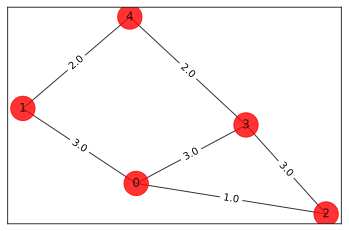

In [9]:
# Generating a graph of 5 nodes

n=5 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,3.0),(0,2,1.0),(0,3,3.0),(1,4,2.0),(3,4,2.0),(2,3,3.0)]
# tuple is (i,j,weight) where (i,j) is the edge

G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    
draw_graph(G, colors, pos)

## Ajacency Matrix

In [10]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print ("Adjacency Matrix:\n")
print(w)

Adjacency Matrix:

[[0. 3. 1. 3. 0.]
 [3. 0. 0. 0. 2.]
 [1. 0. 0. 3. 0.]
 [3. 0. 3. 0. 2.]
 [0. 2. 0. 2. 0.]]


## Create Max-Cut HAMILTONIAN (OPERATOR)

Based on Adjacency Matrix it generates the operator `qubitOp`

See the Part II of this tutorial to check what is under the hood.

In [11]:
# Create MaxCut Hamiltonian Operator with Qiskit
qubitOp, offset = max_cut.get_operator(w)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())
print('Each of the rows is a Hamiltonian Sum Term. Total 6 terms with 5 qubits each.')

Offset: -7.0
Ising Hamiltonian:
IIIZZ	(1.5+0j)
IIZIZ	(0.5+0j)
IZIIZ	(1.5+0j)
IZZII	(1.5+0j)
ZIIZI	(1+0j)
ZZIII	(1+0j)

Each of the rows is a Hamiltonian Sum Term. Total 6 terms with 5 qubits each.


# Quantum Simulation with VQE

Making use of Hamiltonian Operator `qubitOp` as input for the `VQE` qiskit function. 

Note that we comment out the code that would enable VQE with a Cloud real device. As in previous Notebooks, this procedure shows to be **impractical** as we will enter in around 40m queue wait time for each iteration.

In [12]:
# USING Real Cloud Device : Note that this is not efficient as it will enter in a queue for each iteration.
# ************************************************
# provider = IBMQ.get_provider(hub='ibm-q')
# backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and not x.configuration().simulator and x.status().operational==True))
# print("least busy backend: ", backend)
# job = execute(circuit, backend, shots=n_experiments, optimization_level=3)
# job_monitor(job)
# result = job.result()
# ************************************************

# USING The Statevector simulator and VQE
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

# construct VQE
spsa = SPSA(maxiter=64)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=4, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.run(quantum_instance)


2021-02-15 18:02:46,522:qiskit.aqua.quantum_instance:INFO: statevector backend only works with shot=1, changing shots from 1024 to 1.
2021-02-15 18:02:46,522:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.16.1
Backend: 'statevector_simulator (AerProvider)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'u', 'p', 'r', 'rx', 'ry', 'rz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 'sx', 't', 'tdg', 'swap', 'cx', 'cy', 'cz', 'csx', 'cp', 'cu1', 'cu2', 'cu3', 'rxx', 'ryy', 'rzz', 'rzx', 'ccx', 'cswap', 'mcx', 'mcy', 'mcz', 'mcsx', 'mcp', 'mcu1', 'mcu2', 'mcu3', 'mcrx', 'mcry', 'mcrz', 'mcr', 'mcswap', 'unitary', 'diagonal', 'multiplexer', 'initialize', 'kraus', 'roerror', 'delay'], 'coupling_map': None}
{'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1)
{'timeout': None}
{}
{}
Measurement mitigation: None
2021-02-15 18:02:46,552:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
===

2021-02-15 18:02:46,553:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
initial point=[ 2.2915011  -5.60685044 -3.51406148 -3.9663008  -4.07268656  3.92189524
  5.31991014 -2.80764892  4.01815433  4.89953608  0.16299155 -3.20486934
  4.07454007 -3.59696069  3.03436447  1.63287677  5.37095801 -3.36894106
  3.75891723  0.22826859 -3.37337151 -4.19837424 -0.02778464  1.03954849
 -3.96672584]
2021-02-15 18:02:46,574:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.46875856] - 11.98983 (ms), eval count: 1
2021-02-15 18:02:46,579:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2021-02-15 18:02:46,914:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.69387095] - 6.99782 (ms), eval count: 51
2021-02-15 18:02:46,921:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.37979039] - 5.99813 (ms), eval count: 52
2021-02-15 18:02:46,931:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.00396105] - 7.00212 (ms), eval count: 53
2021-02-15 18:02:46,938:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.26204899] - 5.00035 (ms), eval count: 54
2021-02-15 18:02:46,945:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.2545141] - 4.98509 (ms), eval count: 55
2021-02-15 18:02:46,951:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.45788779] - 5.00035 (ms), eval count: 56
2021-02-15 18:02:46,959:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluatio

2021-02-15 18:02:47,303:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.48487554] - 3.99923 (ms), eval count: 106
2021-02-15 18:02:47,312:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.72072047] - 6.99544 (ms), eval count: 107
2021-02-15 18:02:47,318:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.67067774] - 4.99678 (ms), eval count: 108
2021-02-15 18:02:47,327:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.62404974] - 6.99735 (ms), eval count: 109
2021-02-15 18:02:47,334:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.75533053] - 4.99892 (ms), eval count: 110
2021-02-15 18:02:47,340:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.56742519] - 5.00131 (ms), eval count: 111
2021-02-15 18:02:47,347:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

## Display Results

energy: -5.896713575626536
time: 1.06065034866333
max-cut objective: -12.896713575626535
solution: [1. 0. 1. 0. 1.]
solution objective: 13.0


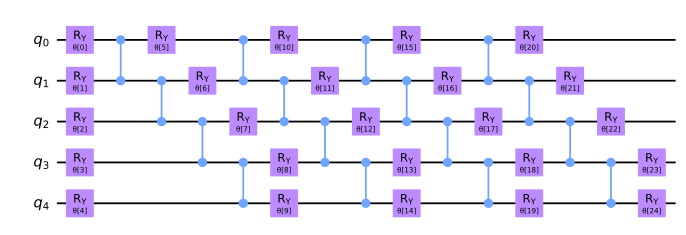

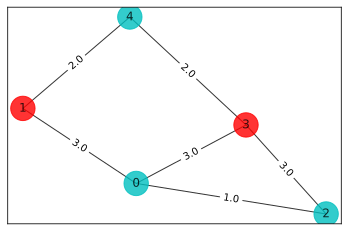

In [13]:
# print results
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))
display(ry.draw(output='mpl',scale=0.9,justify="left"))

# plot results
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

## Final Ansatz State Histogram after VQE

Note:
10 in binary is : 01010
21 in binary is : 10101


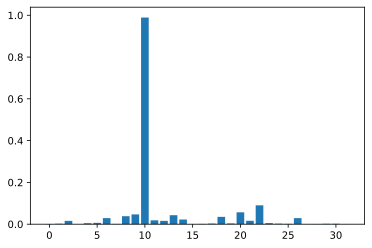

In [14]:
print("Note:")
print("10 in binary is :",format(10, '05b'))
print("21 in binary is :",format(21, '05b'))
plt.bar(list(range(32)),abs(result.eigenstate.real))
plt.show()

---
This part of the tutorial is based on the [Max-Cut and Traveling Salesman Problem](https://qiskit.org/documentation/tutorials/optimization/6_examples_max_cut_and_tsp.html) which is part of the IBM Qiskit documentation.

---